# Import Necessary Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Read data into the data frame object

###### here we will be reading the data and printing the first 5 rows of the data to see how our data looks

In [2]:
fraud_df = pd.read_csv("Fraud.csv")
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## EDA Process

##### what are the data types in our dataset?

In [3]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


##### are there any missing values?

In [4]:
fraud_df.isnull().mean()*100

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

##### Show the target disdribution

In [5]:
fraud_df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

<Axes: xlabel='isFraud', ylabel='Count'>

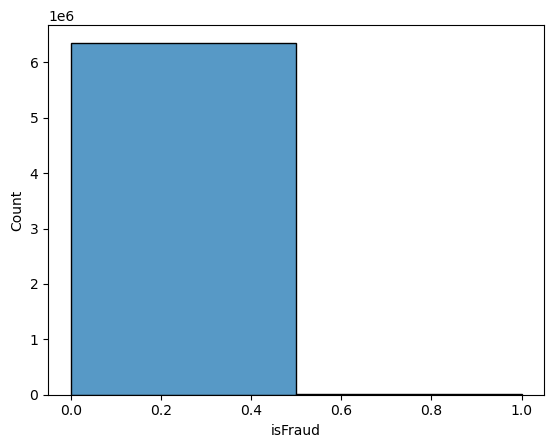

In [6]:
sns.histplot(fraud_df["isFraud"],bins=2,legend=True)

##### Find the outliers in the data

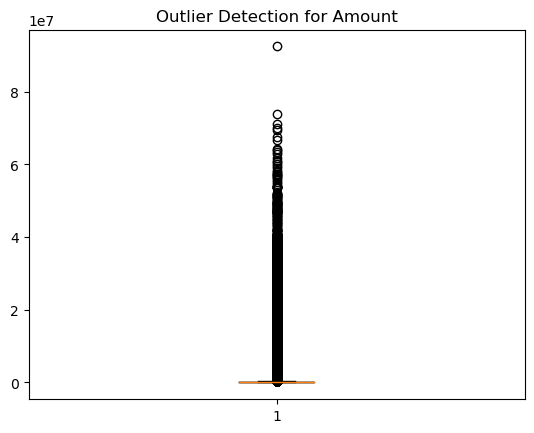

In [7]:
plt.boxplot(fraud_df['amount'])
plt.title('Outlier Detection for Amount')
plt.show()

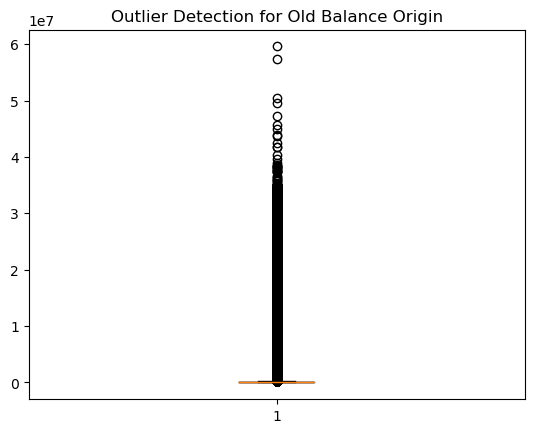

In [8]:
plt.boxplot(fraud_df['oldbalanceOrg'])
plt.title('Outlier Detection for Old Balance Origin')
plt.show()

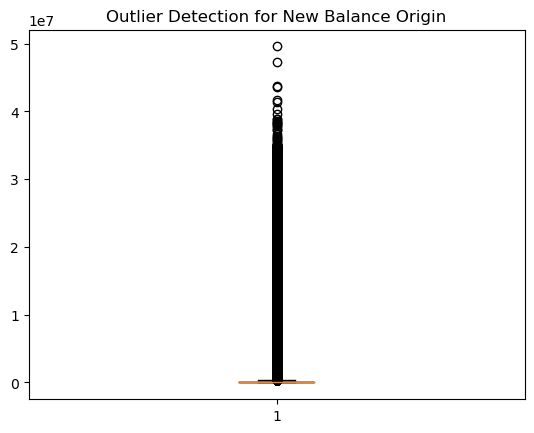

In [9]:
plt.boxplot(fraud_df['newbalanceOrig'])
plt.title('Outlier Detection for New Balance Origin')
plt.show()

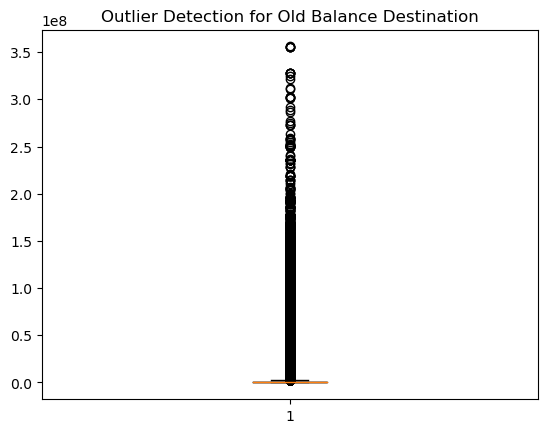

In [10]:
plt.boxplot(fraud_df['oldbalanceDest'])
plt.title('Outlier Detection for Old Balance Destination')
plt.show()

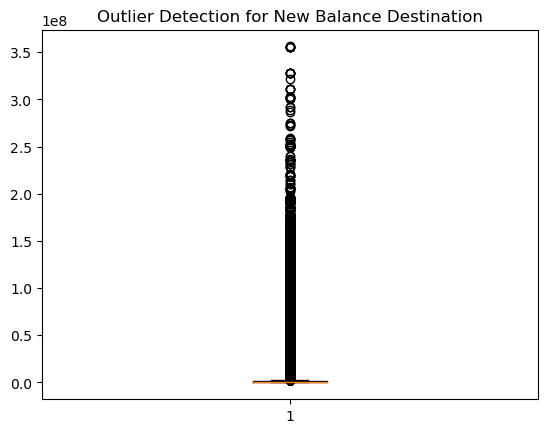

In [11]:
plt.boxplot(fraud_df['newbalanceDest'])
plt.title('Outlier Detection for New Balance Destination')
plt.show()

In [12]:
fraud_df.query('amount>80000000')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3686583,276,TRANSFER,92445516.64,C1715283297,0.0,0.0,C439737079,9595.98,92455112.62,0,0


In [13]:
fraud_df.query('oldbalanceOrg>50000000')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5996399,425,TRANSFER,10000000.0,C40489106,59585040.37,49585040.37,C650095152,0.0,0.0,1,0
6281474,646,TRANSFER,10000000.0,C590657619,50399045.08,40399045.08,C1971187430,0.0,0.0,1,0
6362452,730,TRANSFER,10000000.0,C726730575,57316255.05,47316255.05,C1364745638,0.0,0.0,1,0


In [14]:
fraud_df.query('newbalanceOrig>40000000')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4180200,304,PAYMENT,8301.85,C1568160039,41699144.49,41690842.64,M1906748245,0.00,0.00,0,0
4180201,304,CASH_OUT,258483.17,C438977024,41690842.64,41432359.46,C1162702437,6449276.06,6707759.23,0,0
4203639,305,CASH_OUT,132238.97,C559275248,43818855.30,43686616.33,C1114436169,5327024.57,5459263.54,0,0
4203640,305,PAYMENT,12814.12,C2080486364,43686616.33,43673802.21,M928977012,0.00,0.00,0,0
5996399,425,TRANSFER,10000000.00,C40489106,59585040.37,49585040.37,C650095152,0.00,0.00,1,0
6281474,646,TRANSFER,10000000.00,C590657619,50399045.08,40399045.08,C1971187430,0.00,0.00,1,0
6362452,730,TRANSFER,10000000.00,C726730575,57316255.05,47316255.05,C1364745638,0.00,0.00,1,0


In [15]:
fraud_df.query('oldbalanceDest>350000000')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4596803,328,CASH_IN,171982.69,C758787020,31748.00,203730.69,C439737079,3.555534e+08,3.553814e+08,0,0
4721497,332,CASH_IN,195896.55,C494525103,4178494.78,4374391.33,C439737079,3.553814e+08,3.551855e+08,0,0
5380607,376,CASH_OUT,194946.47,C4896808,0.00,0.00,C439737079,3.551855e+08,3.553805e+08,0,0
5486389,380,TRANSFER,635405.82,C1666289749,0.00,0.00,C439737079,3.553805e+08,3.560159e+08,0,0
5920180,404,CASH_OUT,163389.56,C1323053481,0.00,0.00,C439737079,3.560159e+08,3.561793e+08,0,0


In [16]:
fraud_df.query('newbalanceDest>350000000')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4124250,302,TRANSFER,3325263.90,C1812458696,0.00,0.00,C439737079,3.215898e+08,3.555534e+08,0,0
4133583,302,TRANSFER,30638354.89,C1800693711,0.00,0.00,C439737079,3.249151e+08,3.555534e+08,0,0
4596803,328,CASH_IN,171982.69,C758787020,31748.00,203730.69,C439737079,3.555534e+08,3.553814e+08,0,0
4721497,332,CASH_IN,195896.55,C494525103,4178494.78,4374391.33,C439737079,3.553814e+08,3.551855e+08,0,0
5380607,376,CASH_OUT,194946.47,C4896808,0.00,0.00,C439737079,3.551855e+08,3.553805e+08,0,0
5486389,380,TRANSFER,635405.82,C1666289749,0.00,0.00,C439737079,3.553805e+08,3.560159e+08,0,0
5920180,404,CASH_OUT,163389.56,C1323053481,0.00,0.00,C439737079,3.560159e+08,3.561793e+08,0,0


##### Show how much of each transaction type has contributed to the data

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'CASH_OUT'),
  Text(1, 0, 'PAYMENT'),
  Text(2, 0, 'CASH_IN'),
  Text(3, 0, 'TRANSFER'),
  Text(4, 0, 'DEBIT')])

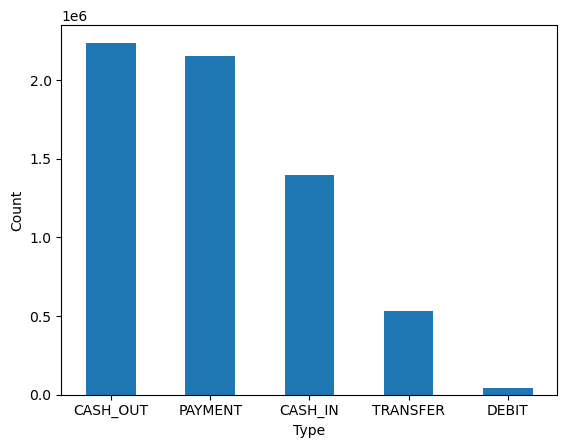

In [17]:
category_count = fraud_df['type'].value_counts()
category_count.plot(kind = 'bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation = 0)

##### Which type of transaction have more fraud cases?

In [18]:
fraud_trans_type = fraud_df.query('isFraud==1').type.value_counts()

In [19]:
fraud_trans_type

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

(array([0, 1]), [Text(0, 0, 'CASH_OUT'), Text(1, 0, 'TRANSFER')])

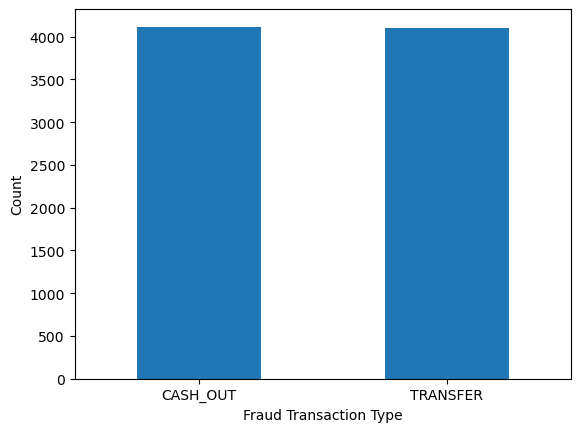

In [20]:
fraud_trans_type.plot(kind='bar')
plt.xlabel('Fraud Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation = 0)

##### Are there any transactions where origin/destination account whose balance is 0 and still the transaction is taking place with a non 0 amount?

<Axes: xlabel='isfraud?', ylabel='count'>

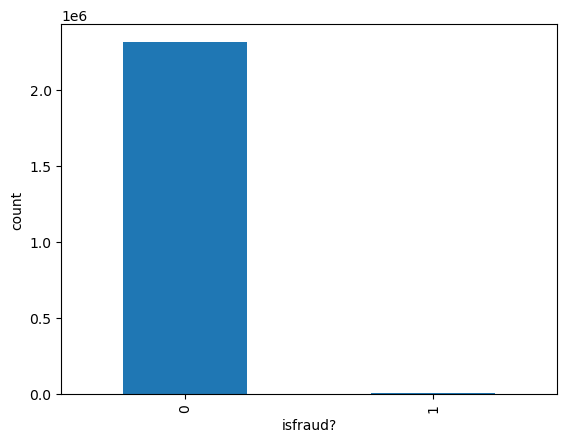

In [21]:
fraud_df.query('oldbalanceDest == 0 and newbalanceDest == 0 and amount!= 0 ').isFraud.value_counts().plot(kind = 'bar',xlabel = 'isfraud?', ylabel = 'count')

<Axes: xlabel='isfraud?', ylabel='count'>

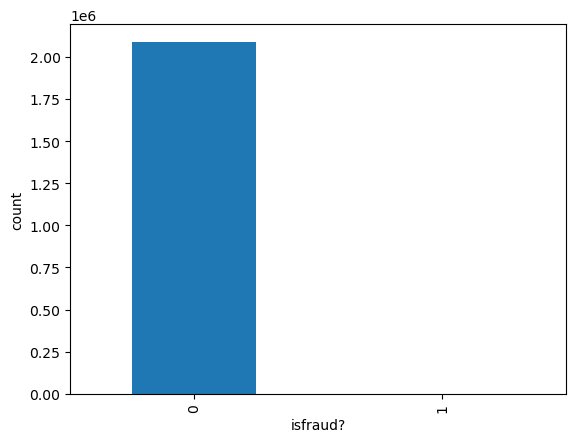

In [22]:
fraud_df.query('oldbalanceOrg == 0 and newbalanceOrig == 0 and amount!= 0 ').isFraud.value_counts().plot(kind = 'bar',xlabel = 'isfraud?', ylabel = 'count')

## Pre-processing on the data for Model Training and Evaluation

##### what is the difference between balances before and after transaction? and is the difference equal to the amount being transferred? 

In [23]:
fraud_df['origbalanceDifference'] = fraud_df['newbalanceOrig']-fraud_df['oldbalanceOrg']

In [24]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-181.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-11668.14


In [25]:
fraud_df['destbalanceDifference'] = fraud_df['newbalanceDest']-fraud_df['oldbalanceDest']

In [26]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-11668.14,0.0


##### how much amount is missing from the account balances after the transaction have taken place?

In [27]:
fraud_df['missingAmountOrig'] = np.round(fraud_df['amount']-fraud_df['origbalanceDifference'].abs(),0)

In [28]:
fraud_df.query('missingAmountOrig >0')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.00,0.00,0,0,-2671.0,0.00,1353.0
10,1,DEBIT,9644.94,C1900366749,4465.00,0.00,C997608398,10845.00,157982.12,0,0,-4465.0,147137.12,5180.0
13,1,PAYMENT,11633.76,C1716932897,10127.00,0.00,M801569151,0.00,0.00,0,0,-10127.0,0.00,1507.0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0,-15325.0,46430.44,213809.0
16,1,PAYMENT,1563.82,C761750706,450.00,0.00,M1731217984,0.00,0.00,0,0,-450.0,0.00,1114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362321,718,CASH_OUT,186273.84,C102120699,168046.00,0.00,C1515639522,24893.67,211167.51,0,0,-168046.0,186273.84,18228.0
6362322,718,TRANSFER,82096.45,C614459560,13492.00,0.00,C855350324,0.00,82096.45,0,0,-13492.0,82096.45,68604.0
6362460,730,TRANSFER,10000000.00,C2140038573,17316255.05,17316255.05,C1395467927,0.00,0.00,1,1,0.0,0.00,10000000.0
6362462,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.00,0.00,1,1,0.0,0.00,7316255.0


In [29]:
fraud_df['missingAmountDest'] = np.round(fraud_df['amount']-fraud_df['destbalanceDifference'].abs(),2)

In [30]:
fraud_df.query('missingAmountDest >0')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,-9839.64,0.00,-0.0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,-1864.28,0.00,0.0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,-181.00,0.00,0.0,181.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,-11668.14,0.00,0.0,11668.14
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0,0,-7817.71,0.00,0.0,7817.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.00,C1470998563,0.00,0.00,1,0,-1258818.82,0.00,0.0,1258818.82
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,0,-339682.13,0.00,0.0,339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,-6311409.28,0.00,0.0,6311409.28
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,-6311409.28,6311409.27,0.0,0.01


##### Is the amount actually missing or more amount is introduced in the transaction? What is the amount? 

In [31]:
condition = (fraud_df['missingAmountOrig'].abs() == fraud_df['missingAmountDest'].abs()) &\
            (fraud_df['missingAmountOrig'].abs() == np.round(fraud_df['amount'])) &\
            (fraud_df['amount'] !=0)
    

fraud_df['actualmissingAmount'] = np.round(np.where(condition,fraud_df['amount'],fraud_df['missingAmountOrig'].abs() + fraud_df['missingAmountDest'].abs()))

##### how many are the genuine transactions? (no missing amount)

In [32]:
fraud_df.query('actualmissingAmount==0')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount
415,1,CASH_IN,55837.16,C713898436,4849053.05,4904890.21,C100555887,66800.82,10963.66,0,0,55837.16,-55837.16,-0.0,0.00,0.0
641,1,CASH_IN,7322.98,C913242382,6681389.66,6688712.64,C146305349,64966.00,57643.02,0,0,7322.98,-7322.98,0.0,-0.00,0.0
1124,1,DEBIT,6765.12,C67620673,50317.00,43551.88,C1122805102,16803.80,23568.91,0,0,-6765.12,6765.11,-0.0,0.01,0.0
1169,1,CASH_OUT,9980.32,C1589466857,12936.00,2955.68,C1018298342,0.00,9980.32,0,0,-9980.32,9980.32,0.0,0.00,0.0
1171,1,DEBIT,2763.95,C458817438,60249.00,57485.05,C846947180,10137.14,12901.08,0,0,-2763.95,2763.94,0.0,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,0,-63416.99,63416.99,0.0,0.00,0.0
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.00,C1240760502,503464.50,1762283.33,1,0,-1258818.82,1258818.83,0.0,-0.01,0.0
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,-339682.13,339682.13,0.0,0.00,0.0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,-6311409.28,6311409.27,0.0,0.01,0.0


##### how many are non genuine transactions?

In [36]:
fraud_df.query('actualmissingAmount!=0')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0,-9839.64,0.0,-0.0,9839.64,9840.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0,-1864.28,0.0,0.0,1864.28,1864.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0,-181.00,0.0,0.0,181.00,181.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0,-181.00,-21182.0,0.0,-21001.00,21001.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0,-11668.14,0.0,0.0,11668.14,11668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.00,C1812552860,0.0,0.0,1,0,-63416.99,0.0,0.0,63416.99,63417.0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.00,C1470998563,0.0,0.0,1,0,-1258818.82,0.0,0.0,1258818.82,1258819.0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.0,0.0,1,0,-339682.13,0.0,0.0,339682.13,339682.0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.0,0.0,1,0,-6311409.28,0.0,0.0,6311409.28,6311409.0


##### drop the samples where the transaction amount is 0 and there is no missing amount

In [35]:
zero_amount_index = fraud_df.query('amount == 0 and actualmissingAmount == 0').index
fraud_df.drop(index = zero_amount_index,inplace=True)

In [36]:
fraud_df = fraud_df.query('amount > 0')

In [37]:
fraud_df['type'].value_counts()

CASH_OUT    2237484
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [38]:
condition = (fraud_df['actualmissingAmount'] == 0)
fraud_df['actualFraud'] = np.where(condition,0,1)

In [39]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount,actualFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-9839.64,0.0,-0.0,9839.64,9840.0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-1864.28,0.0,0.0,1864.28,1864.0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-181.00,0.0,0.0,181.00,181.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-181.00,-21182.0,0.0,-21001.00,21001.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-11668.14,0.0,0.0,11668.14,11668.0,1


##### what is actual count of Fraud and non fraud Transactions after cleaning the data?

<Axes: >

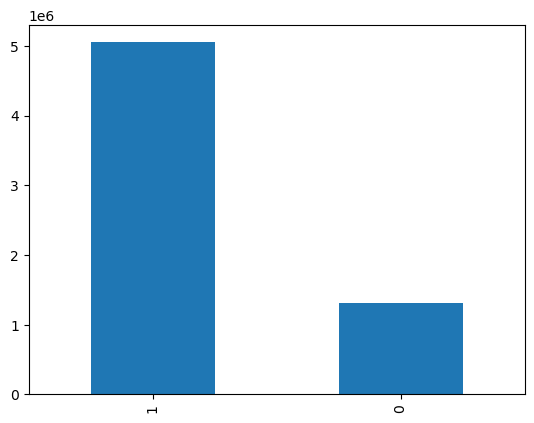

In [40]:
fraud_df['actualFraud'].value_counts().plot(kind = 'bar')

In [41]:
fraud_df.query('oldbalanceOrg ==0 and newbalanceOrig==0 and amount!=0')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount,actualFraud
29,1,PAYMENT,9920.52,C764826684,0.0,0.0,M1940055334,0.00,0.00,0,0,0.0,0.00,9921.0,9920.52,19842.0,1
30,1,PAYMENT,3448.92,C2103763750,0.0,0.0,M335107734,0.00,0.00,0,0,0.0,0.00,3449.0,3448.92,6898.0,1
31,1,PAYMENT,4206.84,C215078753,0.0,0.0,M1757317128,0.00,0.00,0,0,0.0,0.00,4207.0,4206.84,8414.0,1
32,1,PAYMENT,5885.56,C840514538,0.0,0.0,M1804441305,0.00,0.00,0,0,0.0,0.00,5886.0,5885.56,11772.0,1
33,1,PAYMENT,5307.88,C1768242710,0.0,0.0,M1971783162,0.00,0.00,0,0,0.0,0.00,5308.0,5307.88,10616.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355984,709,PAYMENT,3837.05,C1751522910,0.0,0.0,M903863937,0.00,0.00,0,0,0.0,0.00,3837.0,3837.05,7674.0,1
6356000,709,CASH_OUT,104570.26,C606038734,0.0,0.0,C258512603,2890040.30,2994610.55,0,0,0.0,104570.25,104570.0,0.01,104570.0,1
6356051,709,CASH_OUT,244966.80,C2092646234,0.0,0.0,C211766342,5254563.09,5499529.89,0,0,0.0,244966.80,244967.0,0.00,244967.0,1
6356052,709,CASH_OUT,123403.11,C1054278487,0.0,0.0,C1948756721,606875.62,730278.74,0,0,0.0,123403.12,123403.0,-0.01,123403.0,1


In [42]:
fraud_df.query('oldbalanceDest ==0 and newbalanceDest==0 and amount!=0')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount,actualFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0,-9839.64,0.0,-0.0,9839.64,9840.0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0,-1864.28,0.0,0.0,1864.28,1864.0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0,-181.00,0.0,0.0,181.00,181.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0,-11668.14,0.0,0.0,11668.14,11668.0,1
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0,0,-7817.71,0.0,0.0,7817.71,7818.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.00,C1812552860,0.0,0.0,1,0,-63416.99,0.0,0.0,63416.99,63417.0,1
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.00,C1470998563,0.0,0.0,1,0,-1258818.82,0.0,0.0,1258818.82,1258819.0,1
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.0,0.0,1,0,-339682.13,0.0,0.0,339682.13,339682.0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.0,0.0,1,0,-6311409.28,0.0,0.0,6311409.28,6311409.0,1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(CASH_IN, 0)'),
  Text(1, 0, '(CASH_IN, 1)'),
  Text(2, 0, '(CASH_OUT, 1)'),
  Text(3, 0, '(CASH_OUT, 0)'),
  Text(4, 0, '(DEBIT, 0)'),
  Text(5, 0, '(DEBIT, 1)'),
  Text(6, 0, '(PAYMENT, 1)'),
  Text(7, 0, '(PAYMENT, 0)'),
  Text(8, 0, '(TRANSFER, 1)'),
  Text(9, 0, '(TRANSFER, 0)')])

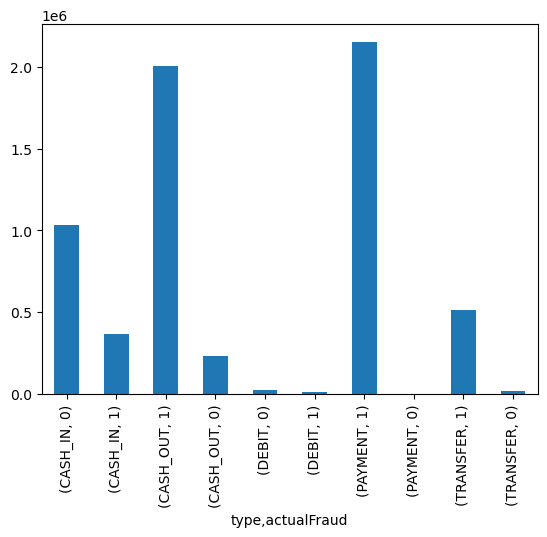

In [43]:
fraud_df['actualFraud'].groupby(fraud_df['type']).value_counts().plot(kind = 'bar')
plt.xticks(rotation=90)

##### drop the outliers.

In [44]:
indexNames = fraud_df[fraud_df['amount'] > 80000000].index
fraud_df.drop(indexNames , inplace=True)

indexNames = fraud_df[fraud_df['oldbalanceOrg'] > 50000000].index
fraud_df.drop(indexNames , inplace=True)

indexNames = fraud_df[fraud_df['newbalanceOrig'] > 40000000].index
fraud_df.drop(indexNames , inplace=True)

indexNames = fraud_df[fraud_df['oldbalanceDest'] > 350000000].index
fraud_df.drop(indexNames , inplace=True)

indexNames = fraud_df[fraud_df['newbalanceDest'] > 350000000].index
fraud_df.drop(indexNames , inplace=True)

In [45]:
fraud_df.query('type=="CASH_OUT" or type=="PAYMENT"')[['type','actualFraud']].groupby('type').value_counts()

type      actualFraud
CASH_OUT  1              2004166
          0               233314
PAYMENT   1              2151433
          0                   60
dtype: int64

In [46]:
#modify actualFraud column for 'CASH_OUT'
actualFraud_len = len(fraud_df.query('type=="CASH_OUT" and actualFraud == 1 and actualmissingAmount <5000000'))
no_of_samplestomodify = np.int32(20*(actualFraud_len/100))
sample_choices = np.random.choice(fraud_df.query('type=="CASH_OUT" and actualFraud == 1 and actualmissingAmount <5000000').index,no_of_samplestomodify,replace=False)
sample_choices.shape

fraud_df.loc[sample_choices,'actualFraud'] = 0

fraud_df.loc[sample_choices]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount,actualFraud
116689,11,CASH_OUT,27384.13,C386596340,0.0,0.0,C1626791432,144716.00,172100.13,0,0,0.0,27384.13,27384.0,-0.00,27384.0,0
152171,12,CASH_OUT,217400.01,C1259039478,0.0,0.0,C2038188867,321797.11,539197.13,0,0,0.0,217400.02,217400.0,-0.01,217400.0,0
1626352,157,CASH_OUT,203451.26,C1770779294,0.0,0.0,C1866187941,1298640.17,1502091.42,0,0,0.0,203451.25,203451.0,0.01,203451.0,0
5448856,379,CASH_OUT,247679.95,C537900304,14788.0,0.0,C1986409736,3769889.91,4017569.85,0,0,-14788.0,247679.94,232892.0,0.01,232892.0,0
4526793,326,CASH_OUT,90567.34,C897954346,0.0,0.0,C1699498044,423326.55,513893.89,0,0,0.0,90567.34,90567.0,-0.00,90567.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982898,231,CASH_OUT,125890.06,C340828255,0.0,0.0,C2032924554,18537443.87,18357205.76,0,0,0.0,-180238.11,125890.0,-54348.05,180238.0,0
99980,10,CASH_OUT,407728.73,C1396003833,0.0,0.0,C570409417,607152.81,1014881.54,0,0,0.0,407728.73,407729.0,0.00,407729.0,0
1111236,130,CASH_OUT,15374.93,C794177936,0.0,0.0,C1547918833,160159.57,175534.50,0,0,0.0,15374.93,15375.0,0.00,15375.0,0
6326649,688,CASH_OUT,100329.63,C1871387710,0.0,0.0,C1823121173,838625.70,938955.33,0,0,0.0,100329.63,100330.0,0.00,100330.0,0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(CASH_IN, 0)'),
  Text(1, 0, '(CASH_IN, 1)'),
  Text(2, 0, '(CASH_OUT, 1)'),
  Text(3, 0, '(CASH_OUT, 0)'),
  Text(4, 0, '(DEBIT, 0)'),
  Text(5, 0, '(DEBIT, 1)'),
  Text(6, 0, '(PAYMENT, 1)'),
  Text(7, 0, '(PAYMENT, 0)'),
  Text(8, 0, '(TRANSFER, 1)'),
  Text(9, 0, '(TRANSFER, 0)')])

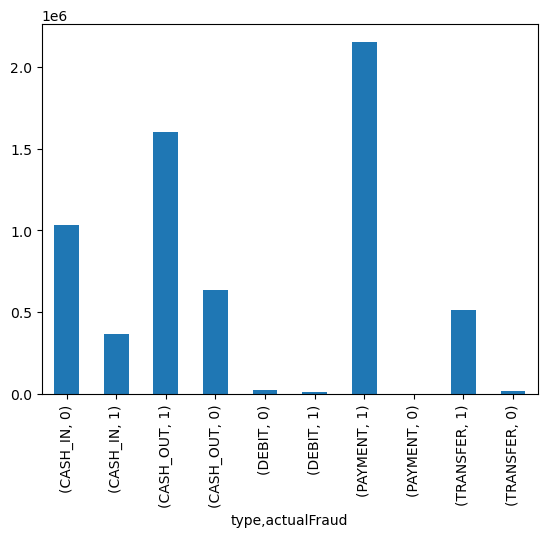

In [47]:
fraud_df['actualFraud'].groupby(fraud_df['type']).value_counts().plot(kind = 'bar')
plt.xticks(rotation=90)

In [48]:
#modify actualFraud column for 'PAYMENT'
payment_actualFraud_len = len(fraud_df.query('type=="PAYMENT" and actualFraud == 1'))
no_of_samplestomodify = np.int32(20*(actualFraud_len/100))
payment_sample_choices = np.random.choice(fraud_df.query('type=="PAYMENT" and actualFraud == 1').index,no_of_samplestomodify,replace=False)

fraud_df.loc[payment_sample_choices,'actualFraud'] = 0

fraud_df.loc[payment_sample_choices]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount,actualFraud
4906790,349,PAYMENT,28898.59,C1075753543,161.00,0.00,M1268920857,0.0,0.0,0,0,-161.00,0.0,28738.0,28898.59,57637.0,0
3147184,236,PAYMENT,11293.30,C417784886,4251.00,0.00,M1763141847,0.0,0.0,0,0,-4251.00,0.0,7042.0,11293.30,18335.0,0
3303372,252,PAYMENT,44151.57,C1346649727,120667.40,76515.83,M1703250307,0.0,0.0,0,0,-44151.57,0.0,0.0,44151.57,44152.0,0
128380,11,PAYMENT,18131.06,C296494880,2662.00,0.00,M1233527792,0.0,0.0,0,0,-2662.00,0.0,15469.0,18131.06,33600.0,0
225374,14,PAYMENT,1132.13,C1714864833,760079.85,758947.72,M1776133650,0.0,0.0,0,0,-1132.13,0.0,-0.0,1132.13,1132.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712166,37,PAYMENT,9181.32,C1814303408,0.00,0.00,M161321420,0.0,0.0,0,0,0.00,0.0,9181.0,9181.32,18362.0,0
3572285,261,PAYMENT,7982.01,C1390623331,0.00,0.00,M469284189,0.0,0.0,0,0,0.00,0.0,7982.0,7982.01,15964.0,0
1611081,156,PAYMENT,4744.50,C1115096150,208100.00,203355.50,M271378466,0.0,0.0,0,0,-4744.50,0.0,0.0,4744.50,4744.0,0
6133067,544,PAYMENT,7900.19,C847467857,0.00,0.00,M374256178,0.0,0.0,0,0,0.00,0.0,7900.0,7900.19,15800.0,0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(CASH_IN, 0)'),
  Text(1, 0, '(CASH_IN, 1)'),
  Text(2, 0, '(CASH_OUT, 1)'),
  Text(3, 0, '(CASH_OUT, 0)'),
  Text(4, 0, '(DEBIT, 0)'),
  Text(5, 0, '(DEBIT, 1)'),
  Text(6, 0, '(PAYMENT, 1)'),
  Text(7, 0, '(PAYMENT, 0)'),
  Text(8, 0, '(TRANSFER, 1)'),
  Text(9, 0, '(TRANSFER, 0)')])

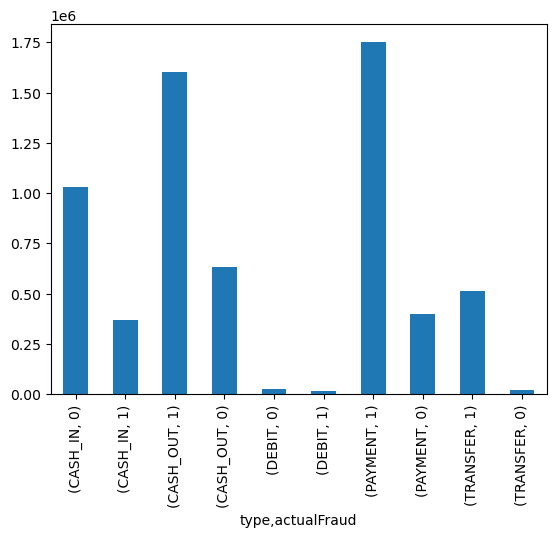

In [49]:
fraud_df['actualFraud'].groupby(fraud_df['type']).value_counts().plot(kind = 'bar')
plt.xticks(rotation=90)

##### Converting categorical feature to numerical features

In [50]:
fraud_df_new = pd.get_dummies(fraud_df,columns=['type'])
fraud_df_new.drop(columns = ['step','nameOrig','nameDest','isFlaggedFraud','isFraud'],inplace=True)

In [51]:
fraud_df_new['actualFraud'].value_counts()

1    4249298
0    2113291
Name: actualFraud, dtype: int64

##### Resampling the target variable to address the class imbalance

In [52]:
np.random.seed(42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X = fraud_df_new.drop(columns=['actualFraud'])
y = fraud_df_new['actualFraud']
X_resampled, y_resampled = smote.fit_resample(X, y)
resampled_df = pd.DataFrame(data = X_resampled,columns = X_resampled.columns)
resampled_df['actualFraud'] = y_resampled

In [53]:
resampled_df['actualFraud'].value_counts()

1    4249298
0    4249298
Name: actualFraud, dtype: int64

<Axes: >

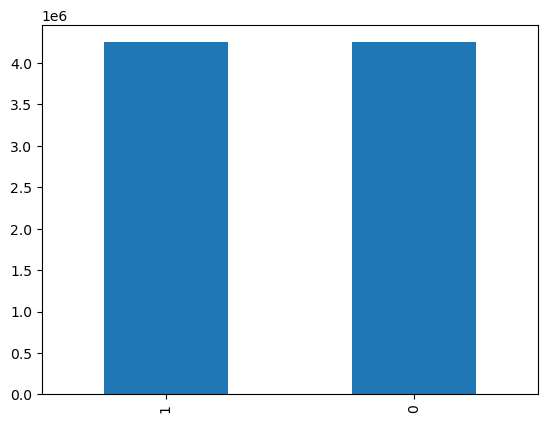

In [54]:
resampled_df['actualFraud'].value_counts().plot(kind='bar')

In [56]:
resampled_df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,origbalanceDifference,destbalanceDifference,missingAmountOrig,missingAmountDest,actualmissingAmount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,actualFraud
0,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,-0.0,9839.64,9840.0,0,0,0,1,0,1
1,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,0.0,1864.28,1864.0,0,0,0,1,0,1
2,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,0.0,181.00,181.0,0,0,0,0,1,1
3,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,0.0,-21001.00,21001.0,0,1,0,0,0,1
4,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,0.0,11668.14,11668.0,0,0,0,1,0,1


## Splitting the Data set and Model Training & Evaluation

In [58]:
reduced_size = np.int64(90*(len(resampled_df)/100))
drop_index = np.random.choice(resampled_df.index,reduced_size,replace = False)
resampled_reduced = resampled_df.drop(index = drop_index)

resampled_reduced['actualFraud'].value_counts()

1    425049
0    424811
Name: actualFraud, dtype: int64

In [59]:
X = resampled_reduced.drop(columns=['actualFraud'])
y = resampled_reduced['actualFraud']

#splitting the data

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [54]:
# function to evaluate the model performance
def model_performance(model_name, model, X_train, y_train, y_test, Y_pred):

    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_test, Y_pred))
    print('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(y_test, Y_pred))
    print('Train accuracy: %f'%model.score(X_train, y_train))

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    print('Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))

    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [63]:
# Using standard scalar to bring all the features on same scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
# function to Plot learning curve
def plot_learning_curve(estimator, X_train, y_train, model_name, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(f"Learning Curves - {model_name}")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing Accuracy")

    plt.legend(loc="best")
    return plt


### Decision Tree

Accuracy: 0.7537006095121549
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76    127317
           1       0.76      0.75      0.75    127641

    accuracy                           0.75    254958
   macro avg       0.75      0.75      0.75    254958
weighted avg       0.75      0.75      0.75    254958

Model name: Decision Tree
Test accuracy (Accuracy Score): 0.753701
Test accuracy (ROC AUC Score): 0.753710
Train accuracy: 0.996867
Area Under the Precision-Recall Curve: 0.315017


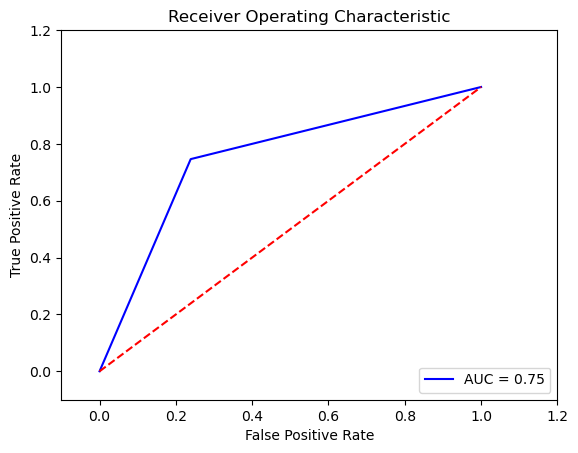

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

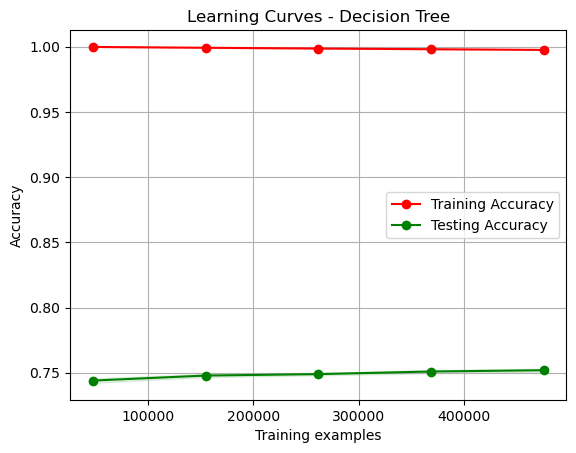

In [69]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

model_performance('Decision Tree',model, X_train, y_train, y_test, y_pred)
plot_learning_curve(model, X_train, y_train, "Decision Tree", cv=5, n_jobs=-1)


### Random Forest

Accuracy: 0.7823170875202975
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77    127317
           1       0.75      0.85      0.80    127641

    accuracy                           0.78    254958
   macro avg       0.79      0.78      0.78    254958
weighted avg       0.79      0.78      0.78    254958

Model name: Random Forest
Test accuracy (Accuracy Score): 0.782317
Test accuracy (ROC AUC Score): 0.782230
Train accuracy: 0.996815
Area Under the Precision-Recall Curve: 0.336443


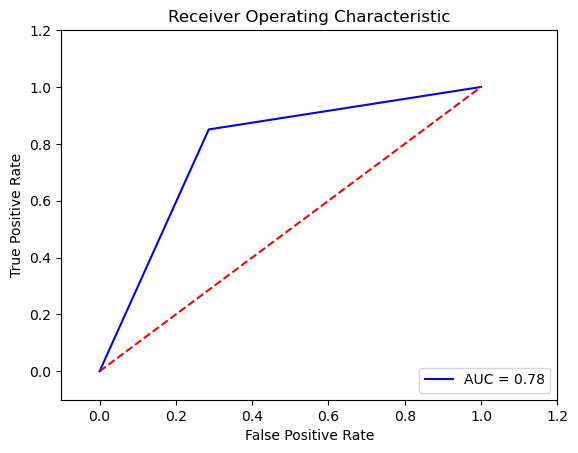

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

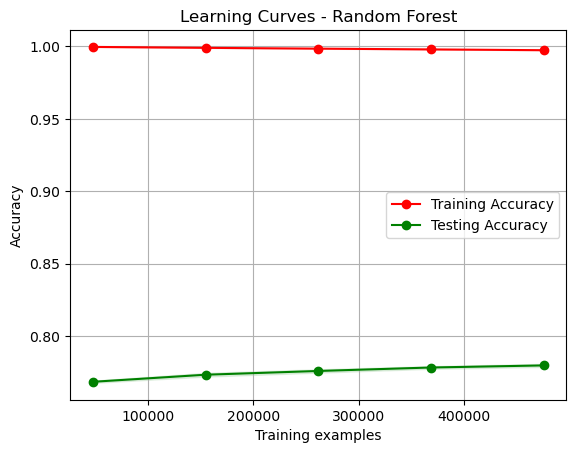

In [71]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, rf_y_pred)
classification_report_str = classification_report(y_test, rf_y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

model_performance('Random Forest', rf_model, X_train, y_train, y_test, rf_y_pred)
plot_learning_curve(rf_model, X_train, y_train, "Random Forest", cv=5, n_jobs=-1)

In [75]:
rf_model.score(X_train,y_train)

0.9996789387159566

### Linear SVC

In [72]:
svm_model = LinearSVC(C=1.0, random_state=42,verbose=2)
svm_model.fit(X_train, y_train)


[LibLinear]

LinearSVC(random_state=42, verbose=2)

Model name: SVM
Test accuracy (Accuracy Score): 0.772974
Test accuracy (ROC AUC Score): 0.772799
Train accuracy: 0.773400
Area Under the Precision-Recall Curve: 0.334246


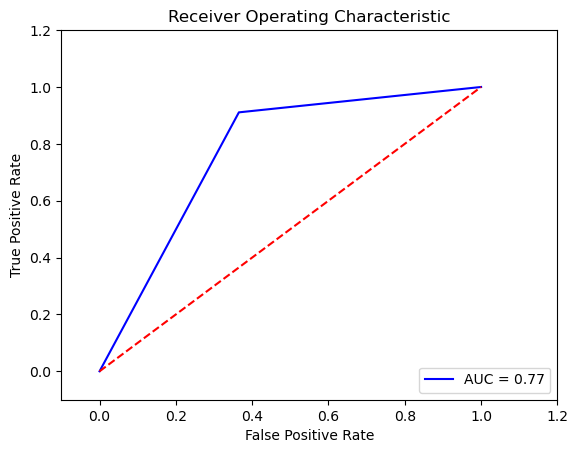

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

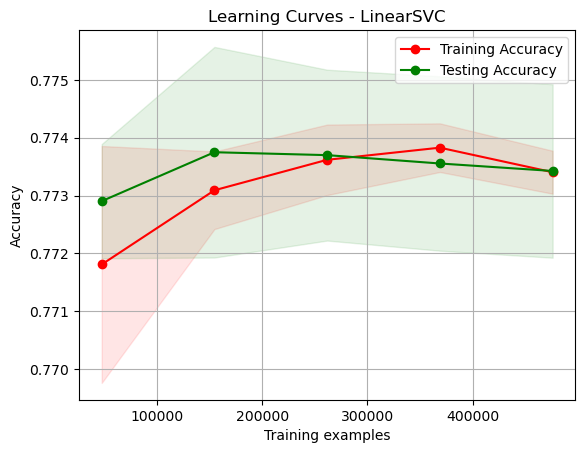

In [73]:
svm_y_pred = svm_model.predict(X_test)
model_performance('SVM', svm_model, X_train, y_train, y_test, svm_y_pred)
plot_learning_curve(svm_model, X_train, y_train, "LinearSVC", cv=5, n_jobs=-1)


### KNN

Model name: KNN
Test accuracy (Accuracy Score): 0.766762
Test accuracy (ROC AUC Score): 0.766685
Train accuracy: 0.843176
Area Under the Precision-Recall Curve: 0.325395


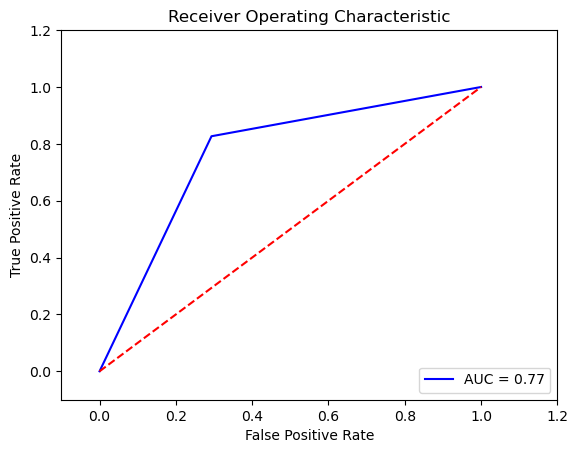

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

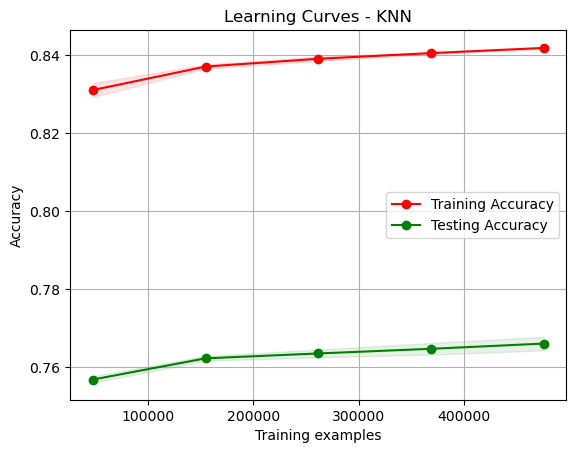

In [74]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)
model_performance('KNN', knn_model, X_train, y_train, y_test, knn_y_pred)
plot_learning_curve(knn_model, X_train, y_train, "KNN", cv=5, n_jobs=-1)


### Logistic Regression

Model name: Logistic Regression
Test accuracy (Accuracy Score): 0.774481
Test accuracy (ROC AUC Score): 0.774310
Train accuracy: 0.774677
Area Under the Precision-Recall Curve: 0.334919


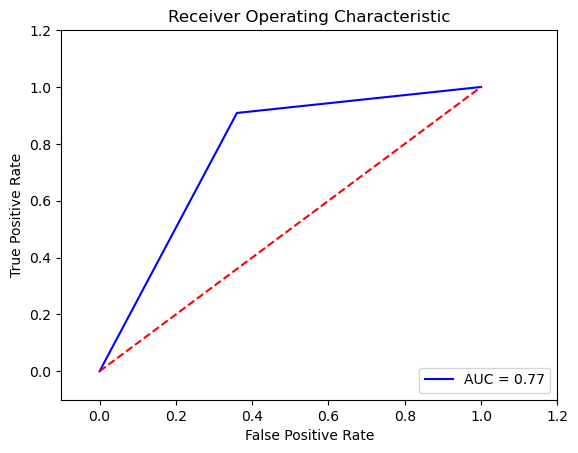

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

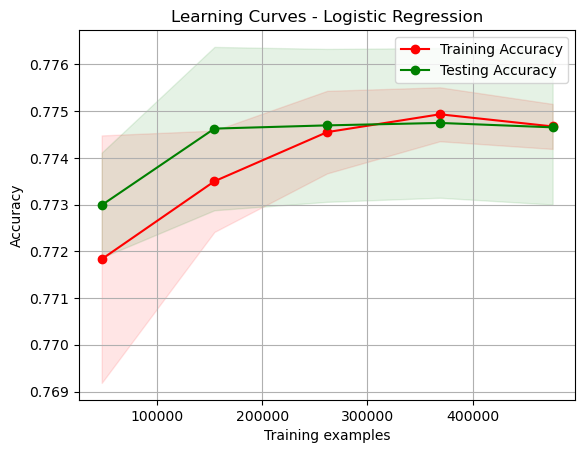

In [75]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_y_pred = logistic_model.predict(X_test)
model_performance('Logistic Regression', logistic_model, X_train, y_train, y_test, logistic_y_pred)
plot_learning_curve(logistic_model, X_train, y_train, "Logistic Regression", cv=5, n_jobs=-1)


### Gradient Boosting Classifier

Model name: Gradient Boosting
Test accuracy (Accuracy Score): 0.809949
Test accuracy (ROC AUC Score): 0.809707
Train accuracy: 0.809508
Area Under the Precision-Recall Curve: 0.361775


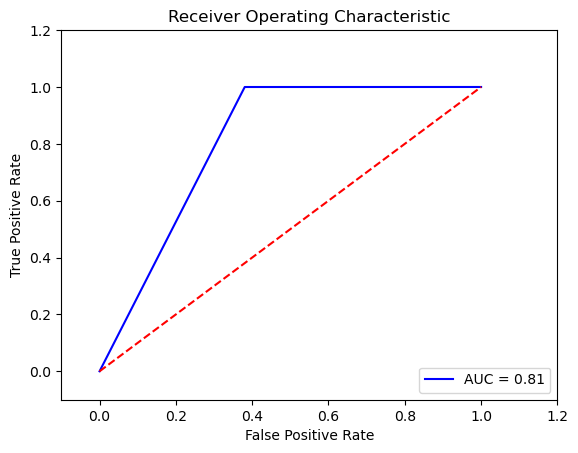

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

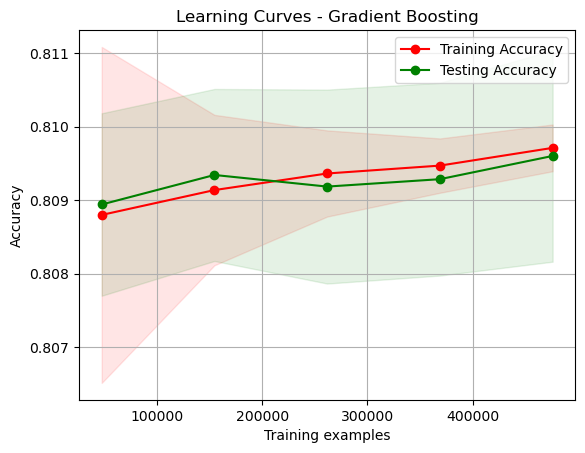

In [76]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)
model_performance('Gradient Boosting', gb_model, X_train, y_train, y_test, gb_y_pred)
plot_learning_curve(gb_model, X_train, y_train, "Gradient Boosting", cv=5, n_jobs=-1)


### Ada Boost Classifier

Model name: AdaBoost
Test accuracy (Accuracy Score): 0.809651
Test accuracy (ROC AUC Score): 0.809409
Train accuracy: 0.809199
Area Under the Precision-Recall Curve: 0.361621


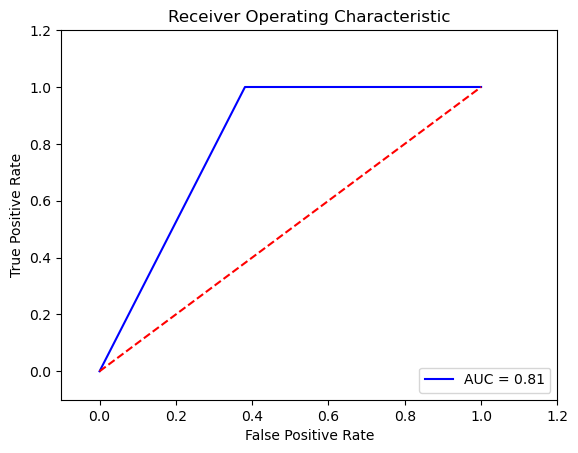

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

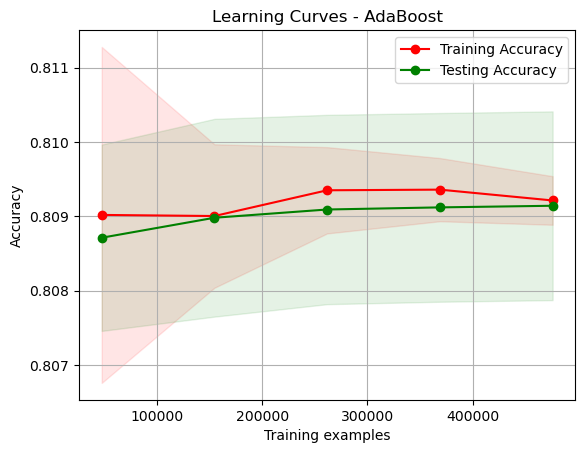

In [77]:
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)
adaboost_y_pred = adaboost_model.predict(X_test)
model_performance('AdaBoost', adaboost_model, X_train, y_train, y_test, adaboost_y_pred)
plot_learning_curve(adaboost_model, X_train, y_train, "AdaBoost", cv=5, n_jobs=-1)


### XG Boost Classifier

Model name: XGBoost
Test accuracy (Accuracy Score): 0.824167
Test accuracy (ROC AUC Score): 0.823947
Train accuracy: 0.825586
Area Under the Precision-Recall Curve: 0.369205


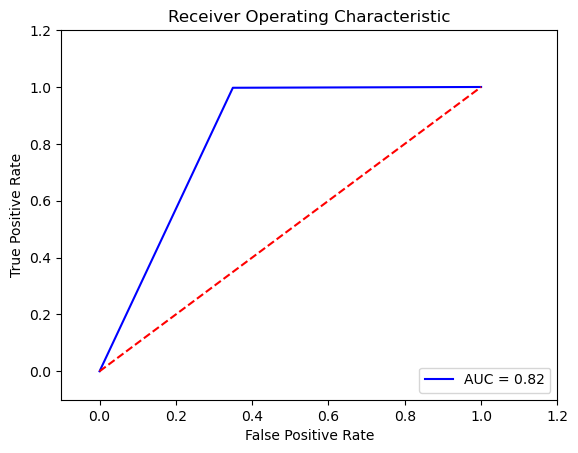

<module 'matplotlib.pyplot' from 'C:\\Users\\KOUSH\\sample-project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

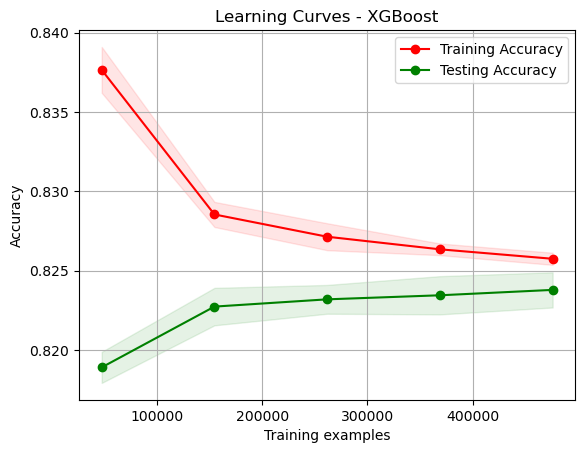

In [78]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
model_performance('XGBoost', xgb_model, X_train, y_train, y_test, xgb_y_pred)
plot_learning_curve(xgb_model, X_train, y_train, "XGBoost", cv=5, n_jobs=-1)


In [70]:
# Function to plot confusion matrix
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

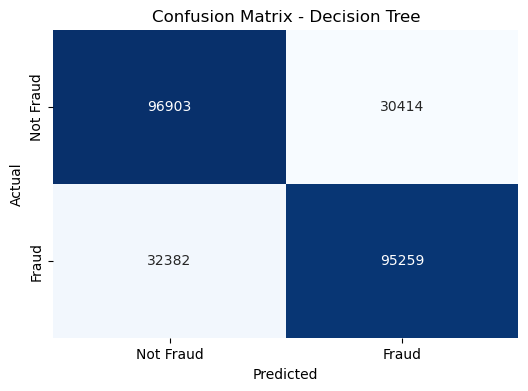

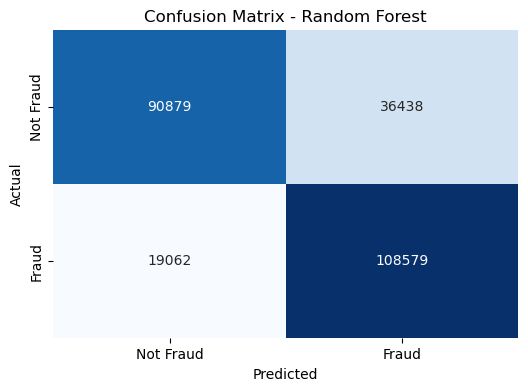

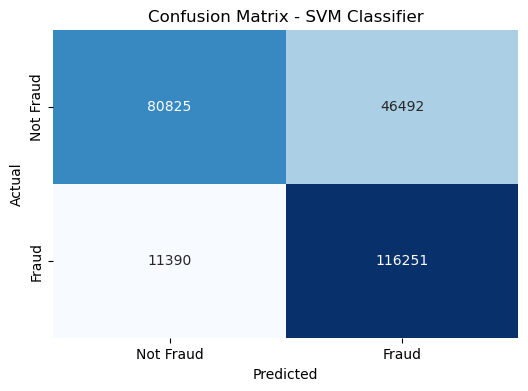

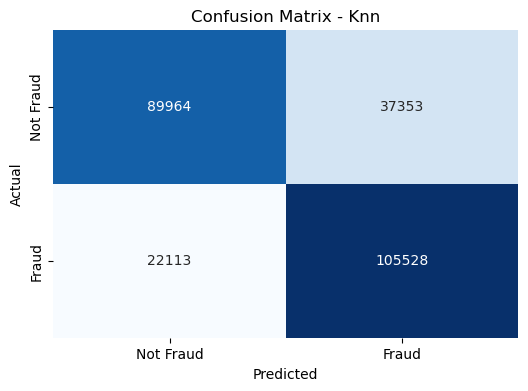

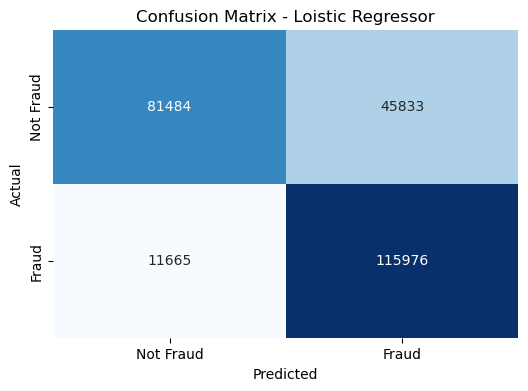

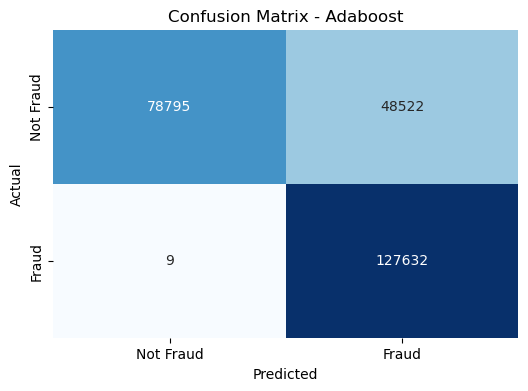

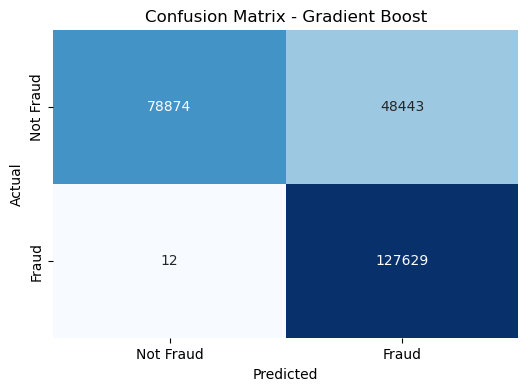

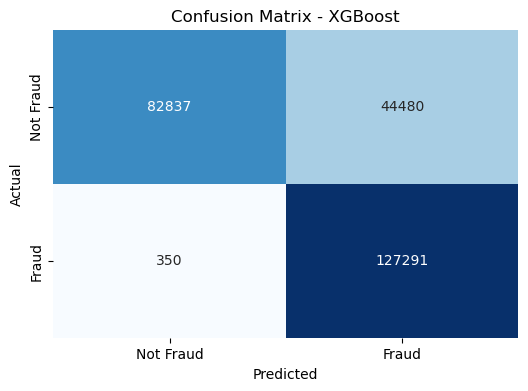

In [80]:
plot_confusion_matrix('Decision Tree',y_test,y_pred)
plot_confusion_matrix('Random Forest',y_test,rf_y_pred)
plot_confusion_matrix('SVM Classifier',y_test,svm_y_pred)
plot_confusion_matrix('Knn',y_test,knn_y_pred)
plot_confusion_matrix('Loistic Regressor',y_test,logistic_y_pred)
plot_confusion_matrix('Adaboost',y_test,adaboost_y_pred)
plot_confusion_matrix('Gradient Boost',y_test,gb_y_pred)
plot_confusion_matrix('XGBoost',y_test,xgb_y_pred)

# Using Cross-validation

In [58]:
def model_performance(model_name, model, X_train, y_train, y_test, Y_pred):

    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_test, Y_pred))
    print('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(y_test, Y_pred))
    print('Train accuracy: %f'%model.score(X_train, y_train))

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    print('Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))

    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [59]:
def plot_learning_curve(estimator, X_train, y_train, model_name, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(f"Learning Curves - {model_name}")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing Accuracy")

    plt.legend(loc="best")
    return plt


In [60]:
def cross_validate_model(model, X, y, cv=5):
    """
    Perform cross-validation for the given model and dataset.

    Parameters:
    - model: The machine learning model to be trained and evaluated.
    - X: Features of the dataset.
    - y: Target variable of the dataset.
    - cv: Number of folds for cross-validation.

    Returns:
    None
    """

    # Cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    model.fit(X, y)

    # Perform cross-validation and get predictions
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    mean_accuracy = scores.mean()

    print(f"\nModel: {model.__class__.__name__}")
    print("Accuracy for each fold:")
    for fold, score in enumerate(scores, 1):
        print(f"Fold {fold}: {score:.4f}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    # Evaluate the model performance
    y_pred_cv = cross_val_predict(model, X, y, cv=kf, method='predict')
    model_performance(model.__class__.__name__, model, X, y, y, y_pred_cv)

    # Plot learning curve
    plot_learning_curve(model, X, y, model.__class__.__name__, cv=cv, n_jobs=-1)

    # Plot confusion matrix
    plot_confusion_matrix(model.__class__.__name__, y, (y_pred_cv > 0.5).astype(int))



In [61]:
# Function to plot confusion matrix
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [61]:
X = resampled_df.drop(columns=['actualFraud'])
y = resampled_df['actualFraud']

#splitting the data

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Decision Tree Classifier using Cross validation method to check for overfitting and under fitting|


Model: DecisionTreeClassifier
Accuracy for each fold:
Fold 1: 0.7846
Fold 2: 0.7845
Fold 3: 0.7845
Fold 4: 0.7851
Fold 5: 0.7841
Mean Accuracy: 0.7845
Model name: DecisionTreeClassifier
Test accuracy (Accuracy Score): 0.784544
Test accuracy (ROC AUC Score): 0.784549
Train accuracy: 0.983152
Area Under the Precision-Recall Curve: 0.338716


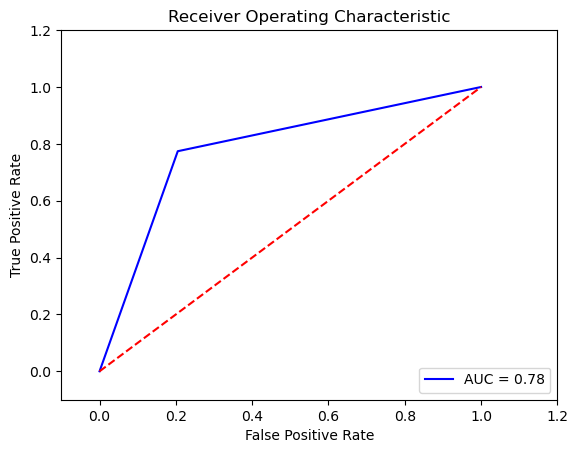

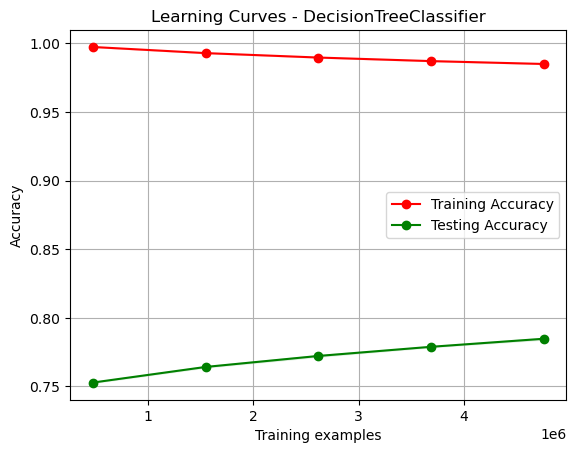

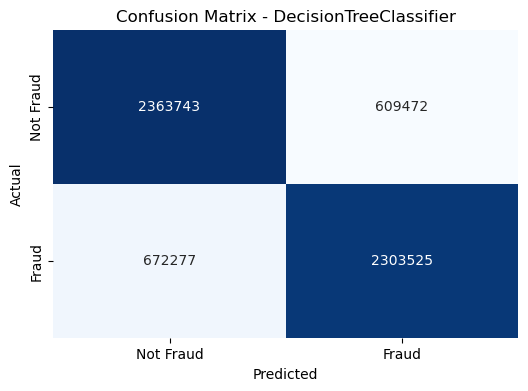

In [65]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(random_state=42)

# Assuming X_train, y_train are your training data
cross_validate_model(decision_tree_model, X_train, y_train)


# Using Pipeline with Random Search CV on all models to check with hyper parameter tuning.

In [58]:
def model_performance(model_name, model, X_train, y_train, y_test, Y_pred):

    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_test, Y_pred))
    print('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(y_test, Y_pred))
    print('Train accuracy: %f'%model.score(X_train, y_train))

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    print('Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))

    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [59]:

def plot_learning_curve(estimator, X_train, y_train, model_name, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(f"Learning Curves - {model_name}")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing Accuracy")

    plt.legend(loc="best")
    return plt


In [60]:
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict

def cross_validate_model(model, X, y, cv=5):
    """
    Perform cross-validation for the given model and dataset.

    Parameters:
    - model: The machine learning model to be trained and evaluated.
    - X: Features of the dataset.
    - y: Target variable of the dataset.
    - cv: Number of folds for cross-validation.

    Returns:
    None
    """

    # Cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    model.fit(X, y)

    # Perform cross-validation and get predictions
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    mean_accuracy = scores.mean()

    print(f"\nModel: {model.__class__.__name__}")
    print("Accuracy for each fold:")
    for fold, score in enumerate(scores, 1):
        print(f"Fold {fold}: {score:.4f}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    # Evaluate the model performance
    y_pred_cv = cross_val_predict(model, X, y, cv=kf, method='predict')
    model_performance(model.__class__.__name__, model, X, y, y, y_pred_cv)

    # Plot learning curve
    plot_learning_curve(model, X, y, model.__class__.__name__, cv=cv, n_jobs=-1)

    # Plot confusion matrix
    plot_confusion_matrix(model.__class__.__name__, y, (y_pred_cv > 0.5).astype(int))



In [61]:
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [62]:
reduced_size = np.int64(90*(len(resampled_df)/100))
drop_index = np.random.choice(resampled_df.index,reduced_size,replace = False)
resampled_reduced = resampled_df.drop(index = drop_index)

X = resampled_reduced.drop(columns=['actualFraud','origbalanceDifference','destbalanceDifference','missingAmountOrig','missingAmountDest','actualmissingAmount'])
y = resampled_reduced['actualFraud']

#splitting the data

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

### Linear SVC

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LibLinear]Best Hyperparameters from RandomizedSearchCV for Linear SVC:
{'svc__penalty': 'l1', 'svc__dual': False, 'svc__C': 0.1}
Model name: Linear SVC (RandomizedSearchCV)
Test accuracy (Accuracy Score): 0.751449
Test accuracy (ROC AUC Score): 0.751474
Train accuracy: 0.751813
Area Under the Precision-Recall Curve: 0.318804


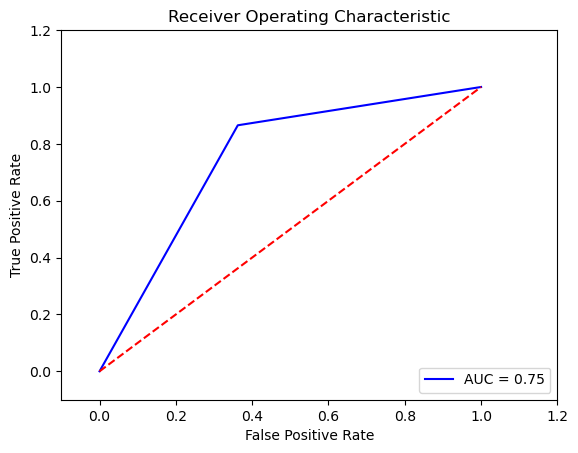

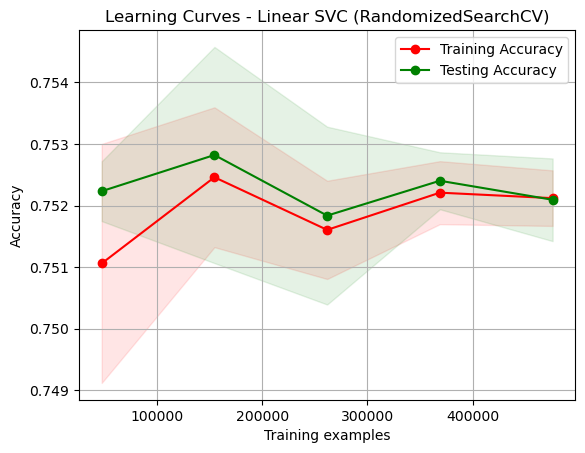

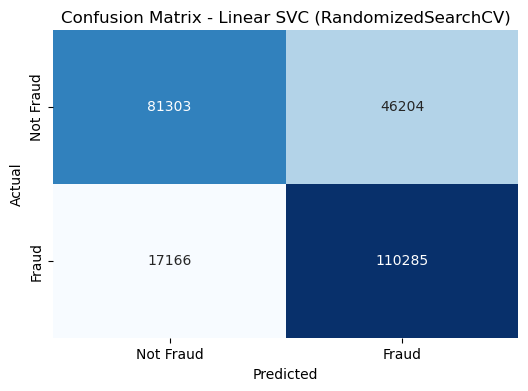

In [65]:
# Create the pipeline
linear_svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(verbose=2))
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist_linear_svc = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svc__penalty': ['l1', 'l2'],
    'svc__dual': [False, True]
}

# Create the RandomizedSearchCV instance
random_search_linear_svc = RandomizedSearchCV(
    linear_svc_pipeline,
    param_distributions=param_dist_linear_svc,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit and transform the data using the pipeline
random_search_linear_svc.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters from RandomizedSearchCV for Linear SVC:")
print(random_search_linear_svc.best_params_)

# Evaluate the model performance
y_pred_linear_svc = random_search_linear_svc.predict(X_test)
model_performance('Linear SVC (RandomizedSearchCV)', random_search_linear_svc, X_train, y_train, y_test, y_pred_linear_svc)
plot_learning_curve(random_search_linear_svc, X_train, y_train, "Linear SVC (RandomizedSearchCV)", cv=5, n_jobs=-1)
plot_confusion_matrix('Linear SVC (RandomizedSearchCV)',y_test,y_pred_linear_svc)


### KNN

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters from RandomizedSearchCV for KNN:
{'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 18}
Model name: KNN (RandomizedSearchCV)
Test accuracy (Accuracy Score): 0.774382
Test accuracy (ROC AUC Score): 0.774047
Train accuracy: 0.798394
Area Under the Precision-Recall Curve: 0.332789


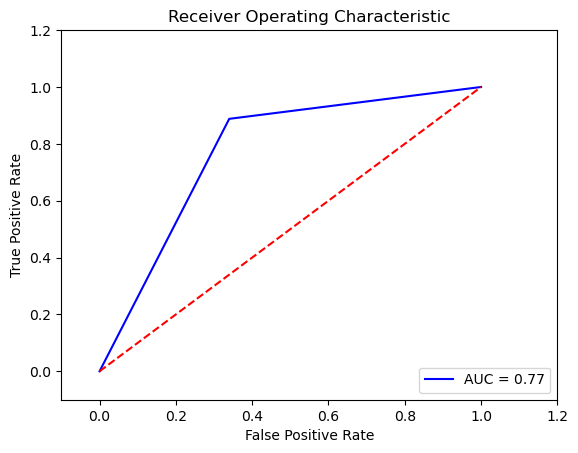

In [ ]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist_knn = {
    'knn__n_neighbors': range(1, 21),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# Create the RandomizedSearchCV instance for KNN

random_search_knn = RandomizedSearchCV(
    knn_pipeline,
    param_distributions=param_dist_knn,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit and transform the data using the pipeline
random_search_knn.fit(X_train, y_train)

# Print the best hyperparameters for KNN
print("Best Hyperparameters from RandomizedSearchCV for KNN:")
print(random_search_knn.best_params_)

# Evaluate the model performance
y_pred_knn = random_search_knn.predict(X_test)
model_performance('KNN (RandomizedSearchCV)', random_search_knn, X_train, y_train, y_test, y_pred_knn)
plot_learning_curve(random_search_knn, X_train, y_train, "KNN (RandomizedSearchCV)", cv=5, n_jobs=-1)
plot_confusion_matrix('KNN (RandomizedSearchCV)', y_test, y_pred_knn)

### Gradient Boosting Classifier

Fitting 5 folds for each of 10 candidates, totalling 50 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3854           0.0009            2.69m
         2           1.3845           0.0009            2.61m
         3           1.3836           0.0009            2.51m
         4           1.3828           0.0009            2.46m
         5           1.3819           0.0009            2.37m
         6           1.3810           0.0009            2.30m
         7           1.3801           0.0009            2.26m
         8           1.3793           0.0009            2.20m
         9           1.3784           0.0009            2.14m
        10           1.3775           0.0009            2.09m
        11           1.3766           0.0009            2.04m
        12           1.3758           0.0009            1.99m
        13           1.3749           0.0009            1.93m
        14           1.3740           0.0009            1.88m
        

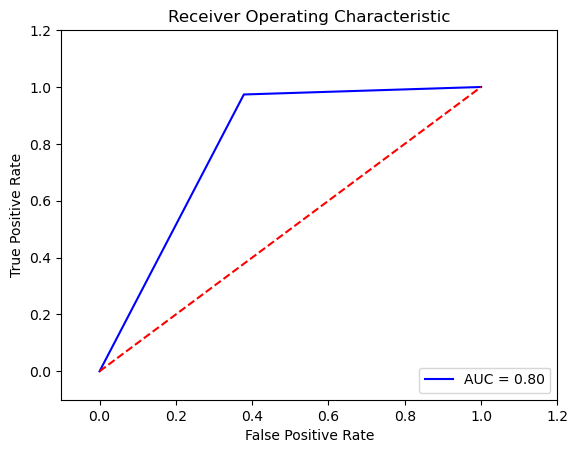

In [63]:
# Create the pipeline for Gradient Boosting
gradient_boost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(verbose = 2))
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist_gradient_boost = {
    'gb__n_estimators': [50, 100],
    'gb__learning_rate': [0.001, 0.01],
    'gb__max_depth': [3, 5],
    'gb__subsample': [0.8],
    'gb__min_samples_split': [2, 5],
    'gb__min_samples_leaf': [1, 2]
}

# Create the RandomizedSearchCV instance for Gradient Boosting
random_search_gradient_boost = RandomizedSearchCV(
    gradient_boost_pipeline,
    param_distributions=param_dist_gradient_boost,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit and transform the data using the pipeline
random_search_gradient_boost.fit(X_train, y_train)

# Print the best hyperparameters for Gradient Boosting
print("Best Hyperparameters from RandomizedSearchCV for Gradient Boosting:")
print(random_search_gradient_boost.best_params_)

# Evaluate the model performance
y_pred_gradient_boost = random_search_gradient_boost.predict(X_test)
model_performance('Gradient Boosting (RandomizedSearchCV)', random_search_gradient_boost, X_train, y_train, y_test, y_pred_gradient_boost)

### XG Boost Classifier

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters from RandomizedSearchCV for XGBoost:
{'xgb__subsample': 0.8, 'xgb__n_estimators': 100, 'xgb__min_child_weight': 1, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.9}
Model name: XGBoost (RandomizedSearchCV)
Test accuracy (Accuracy Score): 0.796508
Test accuracy (ROC AUC Score): 0.796033
Train accuracy: 0.797358
Area Under the Precision-Recall Curve: 0.351776


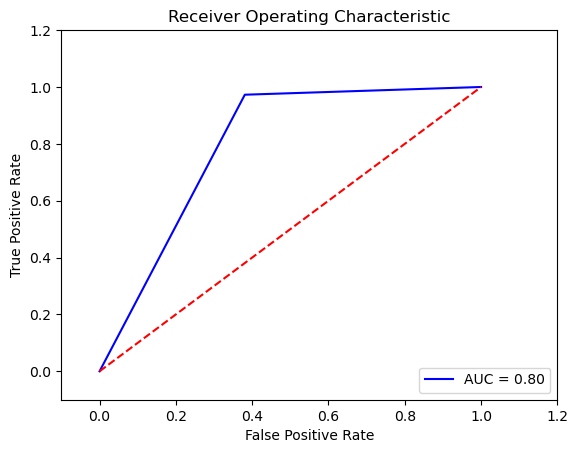

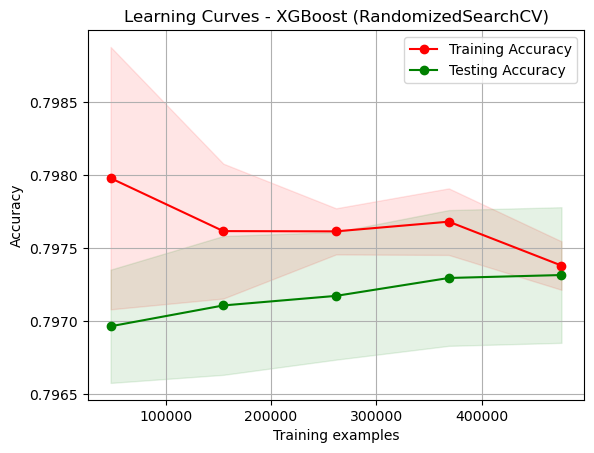

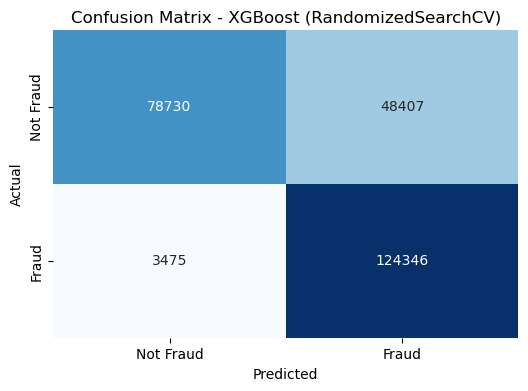

In [64]:
# Create the pipeline for XGBoost
xgboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist_xgboost = {
    'xgb__n_estimators': [50, 100],
    'xgb__learning_rate': [0.001, 0.01],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8],
    'xgb__colsample_bytree': [0.8, 0.9],
    'xgb__min_child_weight': [1, 3]
}

# Create the RandomizedSearchCV instance for XGBoost
random_search_xgboost = RandomizedSearchCV(
    xgboost_pipeline,
    param_distributions=param_dist_xgboost,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit and transform the data using the pipeline
random_search_xgboost.fit(X_train, y_train)

# Print the best hyperparameters for XGBoost
print("Best Hyperparameters from RandomizedSearchCV for XGBoost:")
print(random_search_xgboost.best_params_)

# Evaluate the model performance
y_pred_xgboost = random_search_xgboost.predict(X_test)
model_performance('XGBoost (RandomizedSearchCV)', random_search_xgboost, X_train, y_train, y_test, y_pred_xgboost)
plot_learning_curve(random_search_xgboost, X_train, y_train, "XGBoost (RandomizedSearchCV)", cv=5, n_jobs=-1)
plot_confusion_matrix('XGBoost (RandomizedSearchCV)', y_test, y_pred_xgboost)


### Logistic Regressor Classifier

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters from RandomizedSearchCV for Logistic Regression:
{'logreg__solver': 'liblinear', 'logreg__penalty': 'l1', 'logreg__C': 0.1}
Model name: Logistic Regression (RandomizedSearchCV)
Test accuracy (Accuracy Score): 0.751073
Test accuracy (ROC AUC Score): 0.750813
Train accuracy: 0.751144
Area Under the Precision-Recall Curve: 0.316279


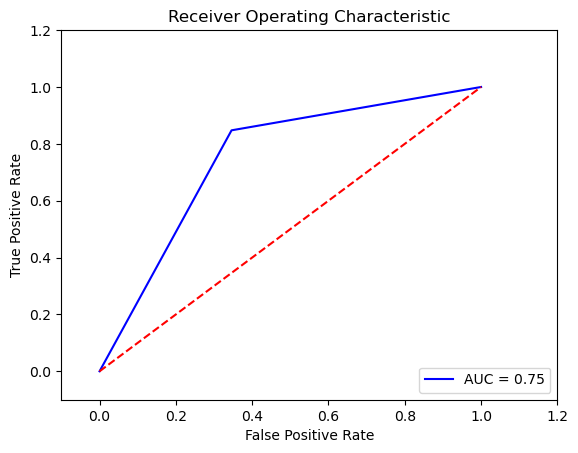

In [65]:
# Create the pipeline for Logistic Regression
logistic_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist_logistic_regression = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.001, 0.01, 0.1],
    'logreg__solver': ['liblinear', 'saga']
}

# Create the RandomizedSearchCV instance for Logistic Regression
random_search_logistic_regression = RandomizedSearchCV(
    logistic_regression_pipeline,
    param_distributions=param_dist_logistic_regression,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit and transform the data using the pipeline
random_search_logistic_regression.fit(X_train, y_train)

# Print the best hyperparameters for Logistic Regression
print("Best Hyperparameters from RandomizedSearchCV for Logistic Regression:")
print(random_search_logistic_regression.best_params_)

# Evaluate the model performance
y_pred_logistic_regression = random_search_logistic_regression.predict(X_test)
model_performance('Logistic Regression (RandomizedSearchCV)', random_search_logistic_regression, X_train, y_train, y_test, y_pred_logistic_regression)

### Ada Boost Classifier

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters from RandomizedSearchCV for AdaBoost:
{'adaboost__n_estimators': 100, 'adaboost__learning_rate': 0.1, 'adaboost__algorithm': 'SAMME.R'}
Model name: AdaBoost (RandomizedSearchCV)
Test accuracy (Accuracy Score): 0.779356
Test accuracy (ROC AUC Score): 0.778951
Train accuracy: 0.780065
Area Under the Precision-Recall Curve: 0.338855


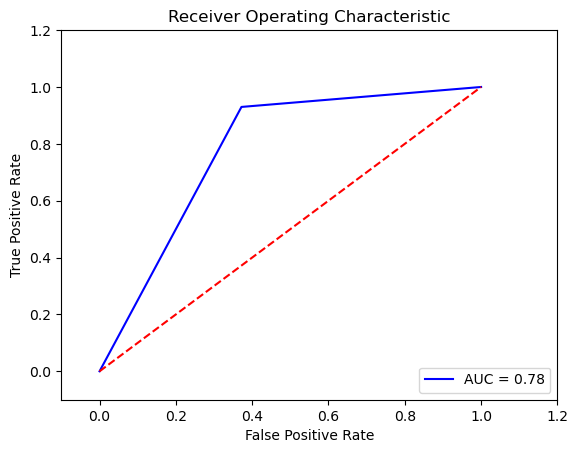

In [66]:
# Create the pipeline for AdaBoost
adaboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier())
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist_adaboost = {
    'adaboost__n_estimators': [50, 100],
    'adaboost__learning_rate': [0.001, 0.01, 0.1],
    'adaboost__algorithm': ['SAMME', 'SAMME.R']
}

# Create the RandomizedSearchCV instance for AdaBoost
random_search_adaboost = RandomizedSearchCV(
    adaboost_pipeline,
    param_distributions=param_dist_adaboost,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit and transform the data using the pipeline
random_search_adaboost.fit(X_train, y_train)

# Print the best hyperparameters for AdaBoost
print("Best Hyperparameters from RandomizedSearchCV for AdaBoost:")
print(random_search_adaboost.best_params_)

# Evaluate the model performance
y_pred_adaboost = random_search_adaboost.predict(X_test)
model_performance('AdaBoost (RandomizedSearchCV)', random_search_adaboost, X_train, y_train, y_test, y_pred_adaboost)

### Random Forest Classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Hyperparameters from RandomizedSearchCV:
{'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 30, 'rf__bootstrap': True}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.4s finished


Model name: Random Forest (RandomizedSearchCV)
Test accuracy (Accuracy Score): 0.801289
Test accuracy (ROC AUC Score): 0.800756


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


Train accuracy: 0.958686
Area Under the Precision-Recall Curve: 0.354245


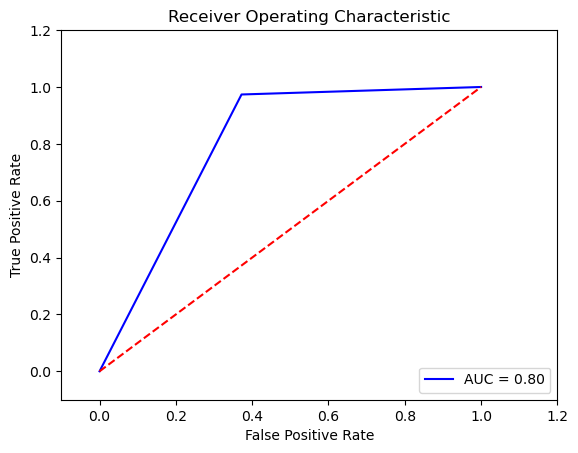

In [64]:
# Create the pipeline
random_forest_pipeline_randomized = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42,verbose = 2))
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

# Fit and transform the data using the pipeline
random_forest_pipeline_randomized.fit(X_train, y_train)

# Create the RandomizedSearchCV instance
random_search_cv = RandomizedSearchCV(
    random_forest_pipeline_randomized,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Perform RandomizedSearchCV
random_search_cv.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters from RandomizedSearchCV:")
print(random_search_cv.best_params_)
y_pred_random_search = random_search_cv.predict(X_test)
model_performance('Random Forest (RandomizedSearchCV)', random_forest_pipeline_randomized, X_train, y_train, y_test, y_pred_random_search)

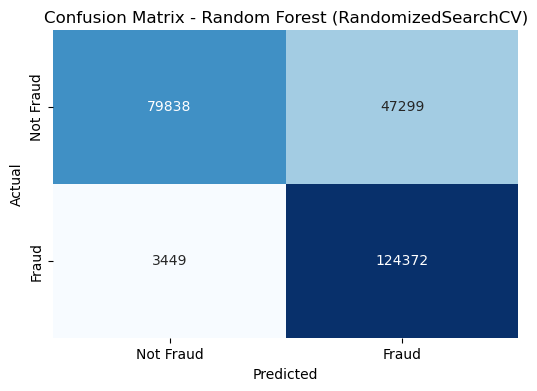

In [69]:
#random forest confusion matrix
plot_confusion_matrix('Random Forest (RandomizedSearchCV)',y_test,y_pred_random_search)

In [66]:
classification_report_str = classification_report(y_test, y_pred_random_search)
print(classification_report_str)

              precision    recall  f1-score   support

           0       0.96      0.63      0.76    127086
           1       0.72      0.97      0.83    127872

    accuracy                           0.80    254958
   macro avg       0.84      0.80      0.79    254958
weighted avg       0.84      0.80      0.80    254958



## based on the above results, Random forest with Random Search CV gives the best result in terms of model performance.

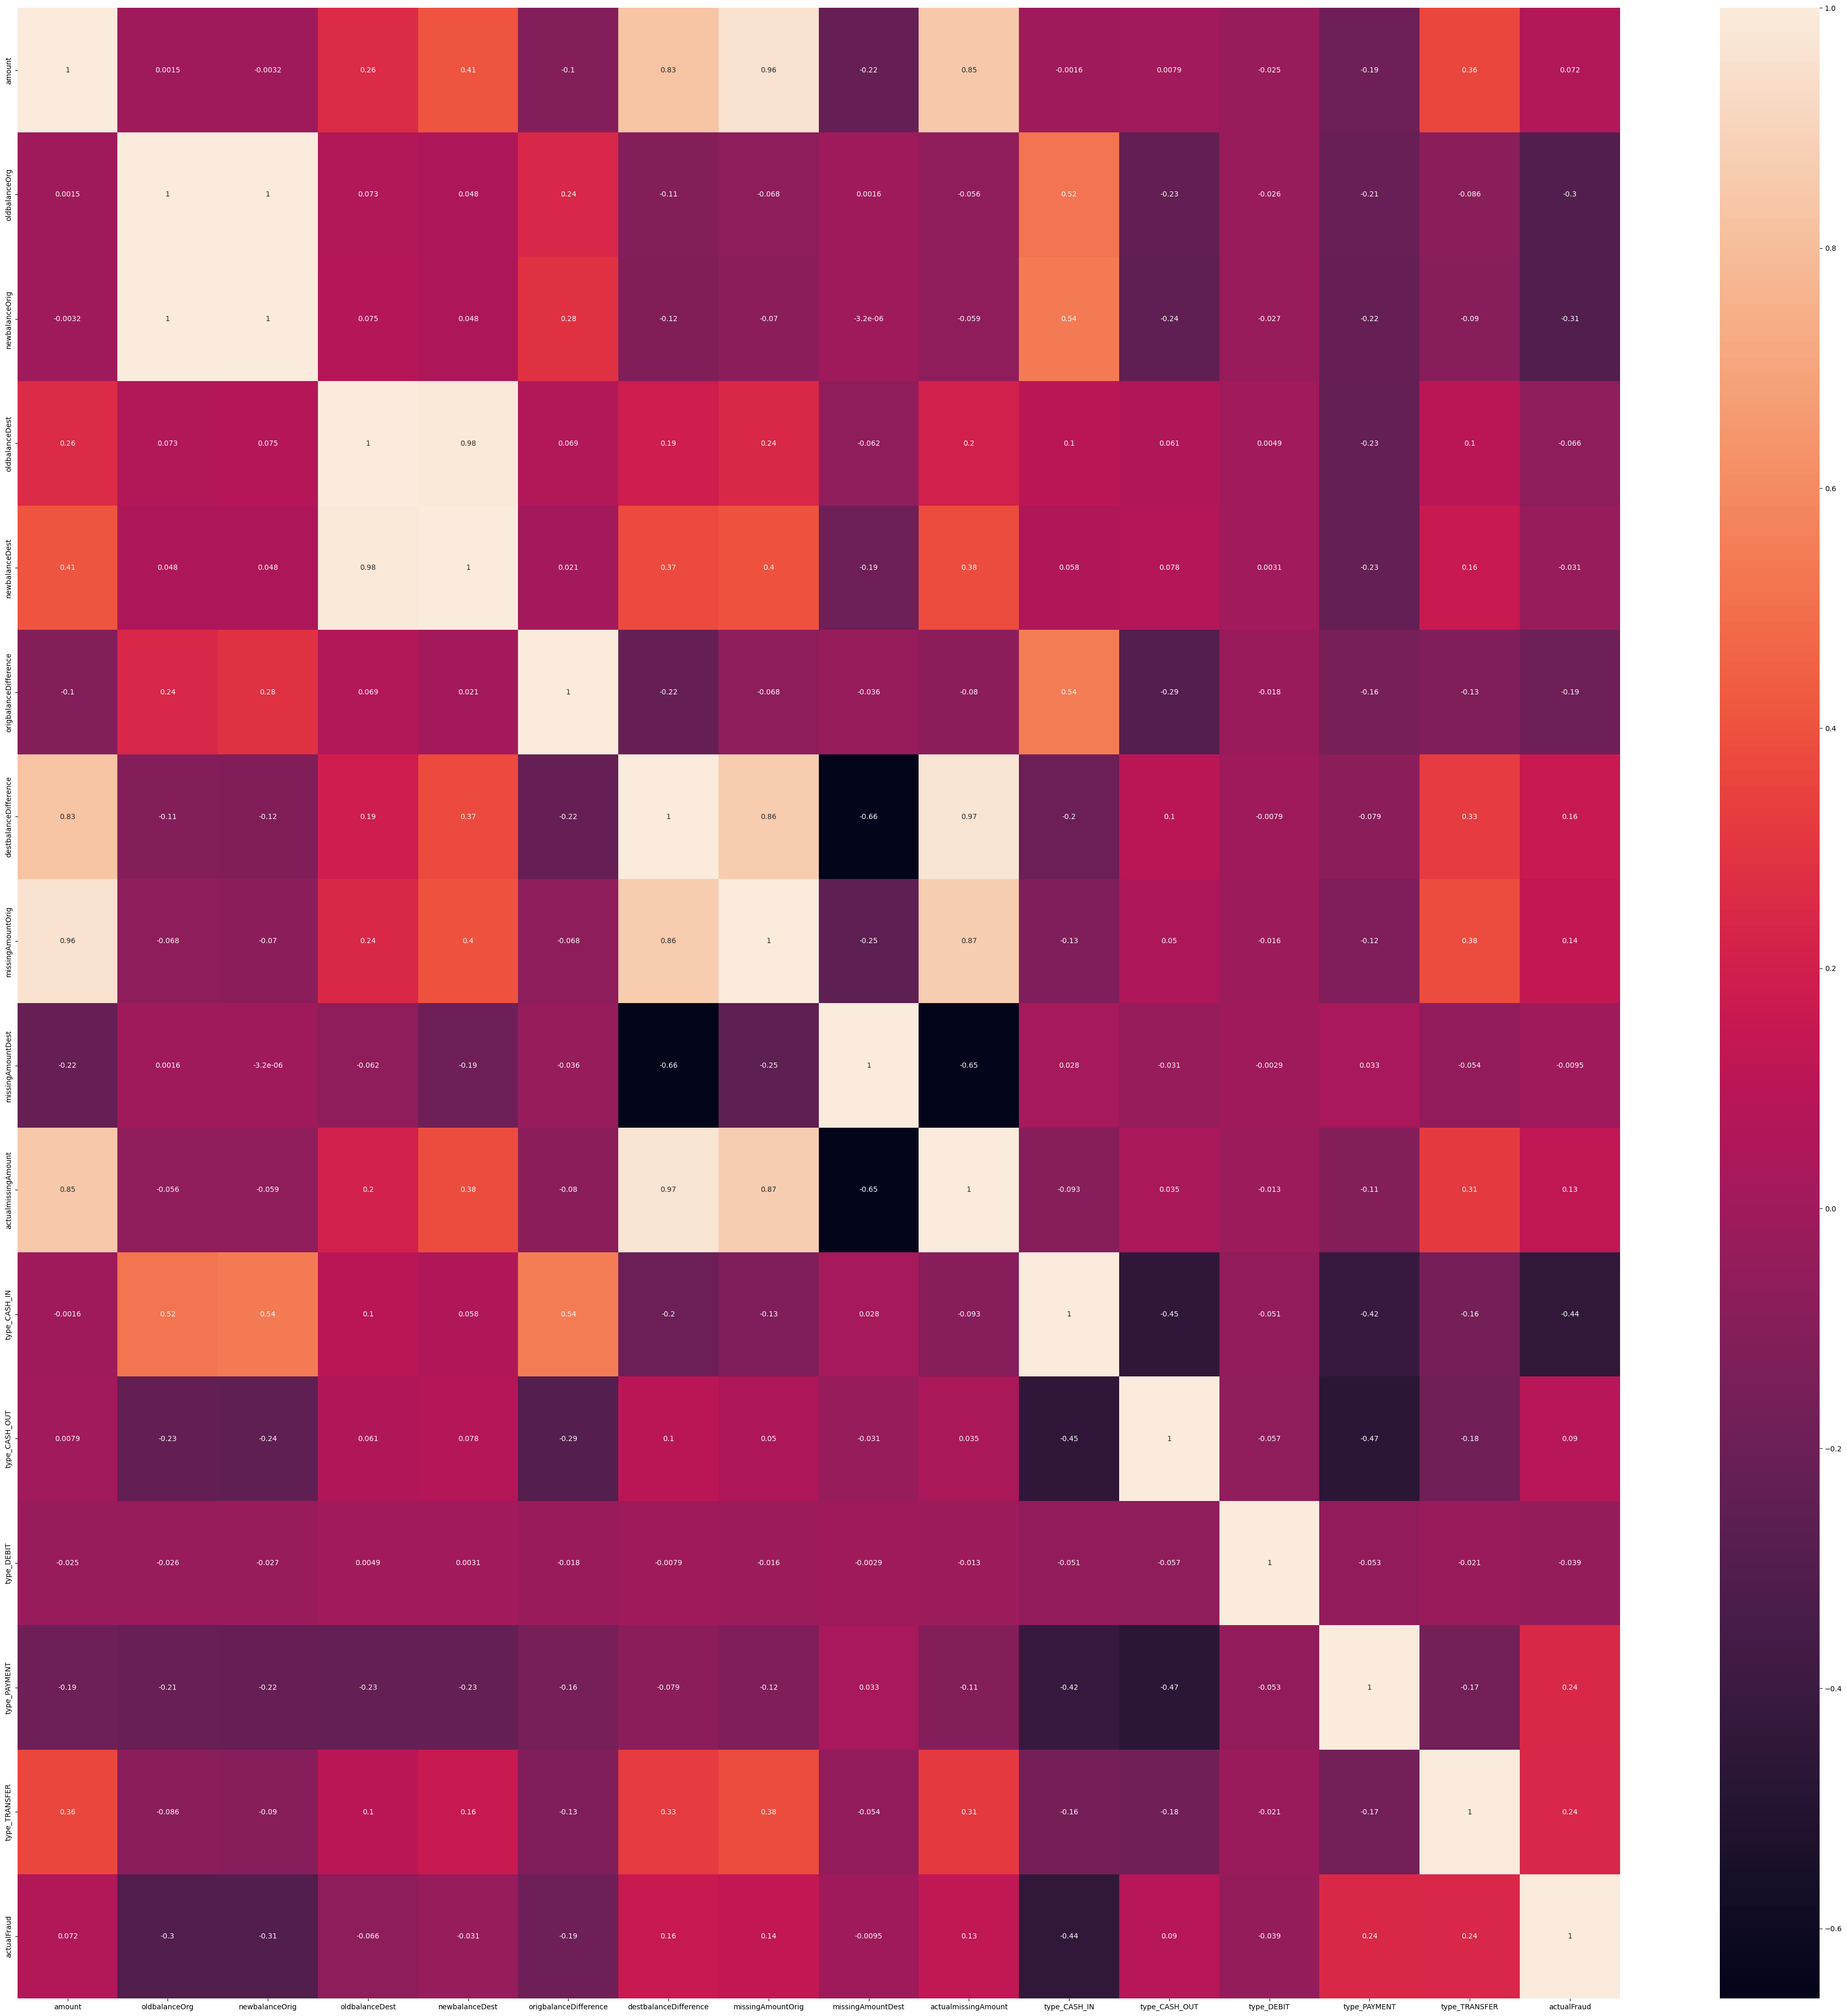

In [64]:
corr = resampled_df.corr()
fig,ax = plt.subplots(figsize = (50,50))
ax = sns.heatmap(data=corr,annot=True)